### Libraries

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from goatools.obo_parser import GODag

import warnings
warnings.filterwarnings("ignore")

### Data loading

In [75]:
#load tpm counts
oe_tpm_counts = pd.read_csv('../data/oe_tpm_counts_kallisto.csv', index_col=0)

#get mean by stage
# Function to extract treatment from sample id
def extract_treatment(sample_id):
    return sample_id[5]

# Apply the function to extract treatment for each sample
oe_tpm_counts['dplex-stage'] = list(oe_tpm_counts.index.map(extract_treatment))

# Group by the Treatment and calculate mean for each gene
oe_mean_tpm_counts_by_stage = oe_tpm_counts.groupby('dplex-stage').mean()

#add pseudo count
oe_mean_tpm_counts_by_stage += 1

# Reordering developmental stages
dev_stages = ['3', '5', 'E', 'L', 'A']
oe_mean_tpm_counts_by_stage = oe_mean_tpm_counts_by_stage.reindex(dev_stages)

#log transform
log_oe_mean_tpm_counts_by_stage = np.log(oe_mean_tpm_counts_by_stage)

#transpose
log_oe_mean_tpm_counts_by_stage = log_oe_mean_tpm_counts_by_stage.T
oe_mean_tpm_counts_by_stage = oe_mean_tpm_counts_by_stage.T

In [76]:
log_oe_mean_tpm_counts_by_stage

dplex-stage,3,5,E,L,A
62541-Oe.00g000010-v1.0.a2,0.000000,0.000000,0.949648,3.566661,0.000000
62541-Oe.00g000020-v1.0.a2,0.685949,0.212495,3.630567,5.938120,1.784253
62541-Oe.00g000030-v1.0.a2,0.709862,1.565167,4.552811,5.563898,3.401441
62541-Oe.00g000040-v1.0.a2,0.465884,0.247251,2.718008,3.702166,1.207383
62541-Oe.00g000050-v1.0.a2,0.097851,0.000000,2.325445,3.290648,2.910607
...,...,...,...,...,...
62541-Oe.00g026290-v1.0.a2,0.000000,0.000000,1.746782,2.502745,0.000000
62541-Oe.00g026300-v1.0.a2,0.000000,0.000000,3.226933,4.148941,2.023224
62541-Oe.00g026310-v1.0.a2,0.000000,0.000000,2.264867,3.402752,1.383015
62541-Oe.00g026320-v1.0.a2,0.000000,0.000000,2.154351,7.441840,2.850012


### K-means clustering

#### Mean center and standardize data

In [6]:
#Extract the data
data = log_oe_mean_tpm_counts_by_stage.values

#Preprocessing - scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

#### Silhouette score as a function of clusters

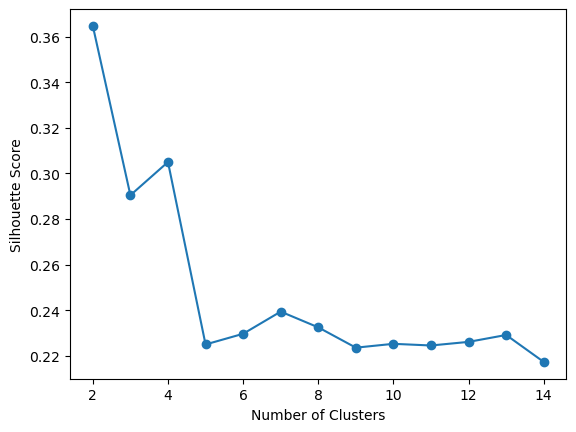

In [7]:
# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to try
cluster_range = range(2, 15)  # You can adjust the range as needed

# Iterate over each cluster number
for n_clusters in cluster_range:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters based on silhouette score
optimal_num_clusters = cluster_range[np.argmax(silhouette_scores)]

# Plot the silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

#### Elbow method

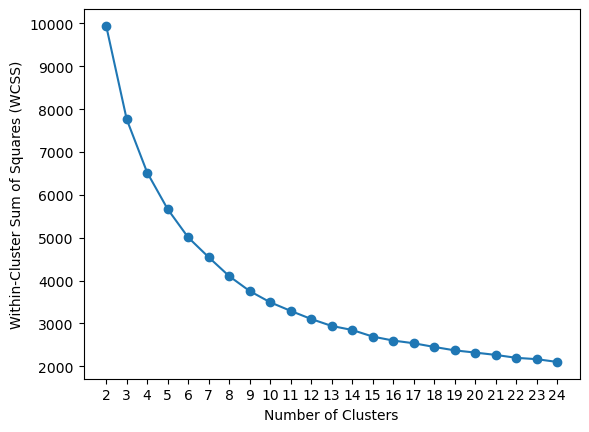

In [8]:
# Initialize an empty list to store the within-cluster sum of squares (WCSS)
wcss = []

# Define a range of cluster numbers to try
cluster_range = range(2, 25)  # You can adjust the range as needed

# Iterate over each cluster number
for n_clusters in cluster_range:
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(scaled_data)
    
    # Calculate within-cluster sum of squares (WCSS)
    wcss.append(kmeans.inertia_)

# Plot the WCSS
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(cluster_range)
plt.show()

#### Perform K-mean clustering

In [9]:
#Applying k-means clustering
kmeans = KMeans(n_clusters=8)
kmeans.fit(scaled_data)
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
log_oe_mean_tpm_counts_by_stage['Cluster'] = cluster_labels

In [13]:
#write clusters to file
log_oe_mean_tpm_counts_by_stage.to_csv('../data/log_oe_mean_tpm_counts_by_stage_clusters.csv')

#### Load clusters

In [18]:
#load data
log_oe_mean_tpm_counts_by_stage = pd.read_csv('../data/log_oe_mean_tpm_counts_by_stage_clusters.csv', index_col=0)

In [19]:
log_oe_mean_tpm_counts_by_stage

,3,5,E,L,A,Cluster
62541-Oe.00g000010-v1.0.a2,0.000000,0.000000,0.949648,3.566661,0.000000,0
62541-Oe.00g000020-v1.0.a2,0.685949,0.212495,3.630567,5.938120,1.784253,5
62541-Oe.00g000030-v1.0.a2,0.709862,1.565167,4.552811,5.563898,3.401441,3
62541-Oe.00g000040-v1.0.a2,0.465884,0.247251,2.718008,3.702166,1.207383,2
62541-Oe.00g000050-v1.0.a2,0.097851,0.000000,2.325445,3.290648,2.910607,2
...,...,...,...,...,...,...
62541-Oe.00g026290-v1.0.a2,0.000000,0.000000,1.746782,2.502745,0.000000,7
62541-Oe.00g026300-v1.0.a2,0.000000,0.000000,3.226933,4.148941,2.023224,2
62541-Oe.00g026310-v1.0.a2,0.000000,0.000000,2.264867,3.402752,1.383015,7
62541-Oe.00g026320-v1.0.a2,0.000000,0.000000,2.154351,7.441840,2.850012,5


#### Visualize in PCA space

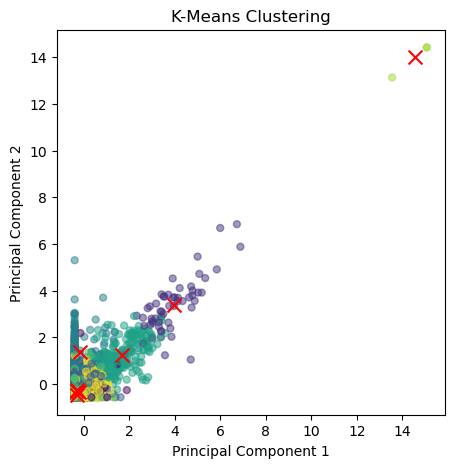

In [20]:
# Visualizing the clustering in PCA space
plt.figure(figsize=(5, 5))
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels, cmap='viridis', s=25, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Visualize clusters

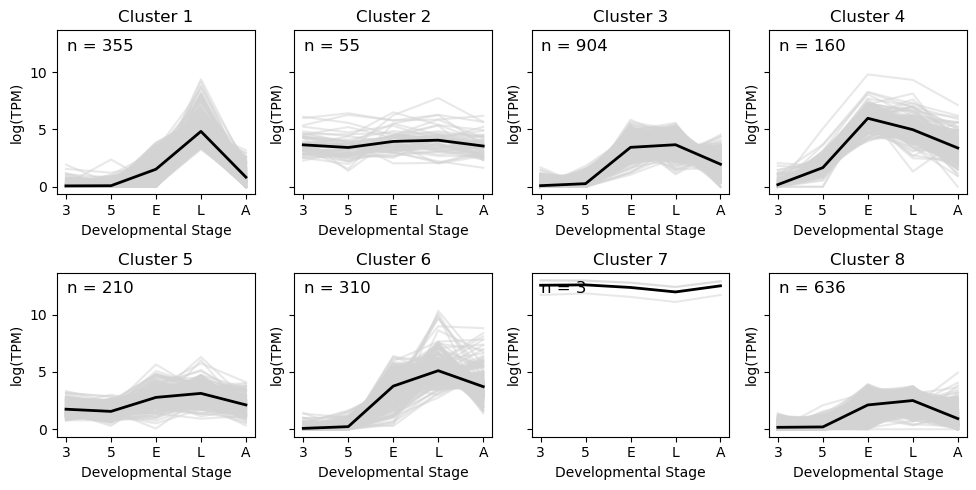

In [21]:
# Create a 2 by 3 grid of subplots for the final clusters
fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for cluster_id, ax in zip(range(n_clusters), axes.flatten()):
    cluster_data = log_oe_mean_tpm_counts_by_stage[log_oe_mean_tpm_counts_by_stage['Cluster'] == cluster_id]
    
    # Plot expression values for each gene in the cluster
    for gene_id, gene_values in cluster_data.iterrows():
        ax.plot(gene_values[:-1], color='lightgray', alpha=0.5)  # Exclude 'Cluster' column
    
    # Calculate and plot the average expression values
    average_values = cluster_data.drop('Cluster', axis=1).mean()
    ax.plot(average_values, color='black', linewidth=2)
    
    ax.set_title(f'Cluster {cluster_id + 1}')
    ax.set_xlabel('Developmental Stage')
    ax.set_ylabel('log(TPM)')
    
    # Add annotation for the number of genes in the cluster
    num_genes = len(cluster_data)
    ax.annotate(f'n = {num_genes}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=12, ha='left', va='top')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Cluster 1: protein phosphorylation, transmembrane transport, proteolysis

Cluster 2: vesicle-mediated transport, protein folding, carbohydrate metabolic process, protein phosphorylation

Cluster 3: protein phosphorylation, rRNA processing, mRNA splicing, via spliceosome, transmembrane transport, DNA-templated transcription

Cluster 4: translation, glycolytic process, translational elongation

Cluster 5: protein phosphorylation, DNA-templated transcription, protein folding, translation

Cluster 6: mRNA splicing, via spliceosome, protein phosphorylation, transmembrane transport, glycolytic process

Cluster 7: 

Cluster 8: protein phosphorylation, vesicle-mediated transport, DNA repair

### Cluster annotations

In [22]:
oe_gene_go_data = pd.read_csv('../data/OE_RNA_scaffolded_interproscan.csv')

In [23]:
oe_gene_go_data

,mRNA,IPR Term,IPR Description,Source,Source Term,GO Terms,Source Description,Alignment
0,62541-Oe.00g000020.m01,IPR011993,PH-like domain superfamily,GENE3D,G3DSA:2.30.29.30,NaN,NaN,coord: 36..172 e-value: 1.1E-38 score: 134.0
1,62541-Oe.00g000020.m01,IPR041316,ISP1 C-terminal,PFAM,PF18161,NaN,ISP1_C,coord: 57..160 e-value: 1.3E-29 score: 102.1
2,62541-Oe.00g000030.m01,IPR002259,Equilibrative nucleoside transporter,PANTHER,PTHR10332,"GO:0016021, GO:1901642, GO:0005337",EQUILIBRATIVE NUCLEOSIDE TRANSPORTER,coord: 35..408
3,62541-Oe.00g000030.m01,IPR002259,Equilibrative nucleoside transporter,PFAM,PF01733,"GO:0016021, GO:1901642, GO:0005337",Nucleoside_tran,coord: 142..408 e-value: 2.8E-16 score: 59.8
4,62541-Oe.00g000030.m01,IPR036259,MFS transporter superfamily,SUPERFAMILY,SSF103473,"GO:0016021, GO:1901642, GO:0005337",MFS general substrate transporter,coord: 30..408
...,...,...,...,...,...,...,...,...
19933,62541-Oe.00g026330.m01,IPR029053,Viral coat protein subunit,GENE3D,G3DSA:2.60.120.20,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",NaN,coord: 1439..1613 e-value: 4.1E-81 score: 272.8
19934,62541-Oe.00g026330.m01,IPR036632,Scaffold protein D superfamily,GENE3D,G3DSA:1.10.1850.10,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",Scaffold protein D,coord: 842..990 e-value: 3.7E-73 score: 246.2
19935,62541-Oe.00g026330.m01,IPR036632,Scaffold protein D superfamily,SUPERFAMILY,SSF48045,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",Scaffolding protein gpD of bacteriophage proca...,coord: 845..986
19936,62541-Oe.00g026330.m01,IPR037002,Microviridae F protein superfamily,GENE3D,G3DSA:2.60.169.10,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",Microviridae F protein,coord: 1027..1435 e-value: 1.3E-128 score: 431.4


In [77]:
log_oe_mean_tpm_counts_by_stage

dplex-stage,3,5,E,L,A
62541-Oe.00g000010-v1.0.a2,0.000000,0.000000,0.949648,3.566661,0.000000
62541-Oe.00g000020-v1.0.a2,0.685949,0.212495,3.630567,5.938120,1.784253
62541-Oe.00g000030-v1.0.a2,0.709862,1.565167,4.552811,5.563898,3.401441
62541-Oe.00g000040-v1.0.a2,0.465884,0.247251,2.718008,3.702166,1.207383
62541-Oe.00g000050-v1.0.a2,0.097851,0.000000,2.325445,3.290648,2.910607
...,...,...,...,...,...
62541-Oe.00g026290-v1.0.a2,0.000000,0.000000,1.746782,2.502745,0.000000
62541-Oe.00g026300-v1.0.a2,0.000000,0.000000,3.226933,4.148941,2.023224
62541-Oe.00g026310-v1.0.a2,0.000000,0.000000,2.264867,3.402752,1.383015
62541-Oe.00g026320-v1.0.a2,0.000000,0.000000,2.154351,7.441840,2.850012


###### assign biological processes

In [67]:
#assign biological processes
# Load GO DAG
go_dag = GODag("../data/go-basic.obo")

../data/go-basic.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms


In [56]:
# Filter to include only biological process terms
go_dag = {go_id: term for go_id, term in go_dag.items() if term.namespace == 'biological_process'}



In [68]:
# Function to get the first GO term and map to biological process
def get_biological_process(go_terms):
    if pd.isna(go_terms):
        return None
    first_go = go_terms.split(',')[0].strip()
    if first_go in go_dag:
        return go_dag[first_go].name
    else:
        return None

oe_gene_go_data['biological_process'] = oe_gene_go_data['GO Terms'].apply(get_biological_process)

In [69]:
oe_gene_go_data

,mRNA,IPR Term,IPR Description,Source,Source Term,GO Terms,Source Description,Alignment,biological_process
0,62541-Oe.00g000020,IPR011993,PH-like domain superfamily,GENE3D,G3DSA:2.30.29.30,NaN,NaN,coord: 36..172 e-value: 1.1E-38 score: 134.0,None
1,62541-Oe.00g000020,IPR041316,ISP1 C-terminal,PFAM,PF18161,NaN,ISP1_C,coord: 57..160 e-value: 1.3E-29 score: 102.1,None
2,62541-Oe.00g000030,IPR002259,Equilibrative nucleoside transporter,PANTHER,PTHR10332,"GO:0016021, GO:1901642, GO:0005337",EQUILIBRATIVE NUCLEOSIDE TRANSPORTER,coord: 35..408,membrane
3,62541-Oe.00g000030,IPR002259,Equilibrative nucleoside transporter,PFAM,PF01733,"GO:0016021, GO:1901642, GO:0005337",Nucleoside_tran,coord: 142..408 e-value: 2.8E-16 score: 59.8,membrane
4,62541-Oe.00g000030,IPR036259,MFS transporter superfamily,SUPERFAMILY,SSF103473,"GO:0016021, GO:1901642, GO:0005337",MFS general substrate transporter,coord: 30..408,membrane
...,...,...,...,...,...,...,...,...,...
19933,62541-Oe.00g026330,IPR029053,Viral coat protein subunit,GENE3D,G3DSA:2.60.120.20,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",NaN,coord: 1439..1613 e-value: 4.1E-81 score: 272.8,structural molecule activity
19934,62541-Oe.00g026330,IPR036632,Scaffold protein D superfamily,GENE3D,G3DSA:1.10.1850.10,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",Scaffold protein D,coord: 842..990 e-value: 3.7E-73 score: 246.2,structural molecule activity
19935,62541-Oe.00g026330,IPR036632,Scaffold protein D superfamily,SUPERFAMILY,SSF48045,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",Scaffolding protein gpD of bacteriophage proca...,coord: 845..986,structural molecule activity
19936,62541-Oe.00g026330,IPR037002,Microviridae F protein superfamily,GENE3D,G3DSA:2.60.169.10,"GO:0005198, GO:0006260, GO:0003677, GO:0046797...",Microviridae F protein,coord: 1027..1435 e-value: 1.3E-128 score: 431.4,structural molecule activity


In [83]:
# Remove ".m01" from "mRNA" column
oe_gene_go_data['mRNA'] = oe_gene_go_data['mRNA'].str.replace(r'\.m\d+$', '', regex=True)

# Group by "mRNA" and keep the first "biological_process" in each group
oe_go_df = oe_gene_go_data.groupby('mRNA').first().reset_index()

# Select only the "mRNA" and "biological_process" columns
oe_go_df = oe_go_df[['mRNA', 'biological_process']]

In [84]:
oe_go_df

,mRNA,biological_process
0,62541-Oe.00g000020,None
1,62541-Oe.00g000030,membrane
2,62541-Oe.00g000040,microtubule binding
3,62541-Oe.00g000050,FAD binding
4,62541-Oe.00g000060,nucleic acid binding
...,...,...
2223,62541-Oe.00g026280,None
2224,62541-Oe.00g026300,None
2225,62541-Oe.00g026310,None
2226,62541-Oe.00g026320,None


In [78]:
log_oe_mean_tpm_counts_by_stage.index = log_oe_mean_tpm_counts_by_stage.index.str.replace(r'-v\d+\.\d+\.a\d+$', '', regex=True)

In [79]:
log_oe_mean_tpm_counts_by_stage

dplex-stage,3,5,E,L,A
62541-Oe.00g000010,0.000000,0.000000,0.949648,3.566661,0.000000
62541-Oe.00g000020,0.685949,0.212495,3.630567,5.938120,1.784253
62541-Oe.00g000030,0.709862,1.565167,4.552811,5.563898,3.401441
62541-Oe.00g000040,0.465884,0.247251,2.718008,3.702166,1.207383
62541-Oe.00g000050,0.097851,0.000000,2.325445,3.290648,2.910607
...,...,...,...,...,...
62541-Oe.00g026290,0.000000,0.000000,1.746782,2.502745,0.000000
62541-Oe.00g026300,0.000000,0.000000,3.226933,4.148941,2.023224
62541-Oe.00g026310,0.000000,0.000000,2.264867,3.402752,1.383015
62541-Oe.00g026320,0.000000,0.000000,2.154351,7.441840,2.850012


In [85]:
# Ensure the index is a column for merging
log_oe_mean_tpm_counts_by_stage.reset_index(inplace=True)

# Rename the index column to match 'mRNA'
log_oe_mean_tpm_counts_by_stage.rename(columns={'index': 'mRNA'}, inplace=True)

# Merge the dataframes
merged_df = log_oe_mean_tpm_counts_by_stage.merge(final_df, on='mRNA', how='left')

# Set the index back to 'mRNA'
merged_df.set_index('mRNA', inplace=True)

ValueError: The column label 'mRNA' is not unique.

In [81]:
merged_df

,3,5,E,L,A,biological_process
mRNA,,,,,,
62541-Oe.00g000010,0.000000,0.000000,0.949648,3.566661,0.000000,NaN
62541-Oe.00g000020,0.685949,0.212495,3.630567,5.938120,1.784253,None
62541-Oe.00g000030,0.709862,1.565167,4.552811,5.563898,3.401441,membrane
62541-Oe.00g000040,0.465884,0.247251,2.718008,3.702166,1.207383,microtubule binding
62541-Oe.00g000050,0.097851,0.000000,2.325445,3.290648,2.910607,FAD binding
...,...,...,...,...,...,...
62541-Oe.00g026290,0.000000,0.000000,1.746782,2.502745,0.000000,NaN
62541-Oe.00g026300,0.000000,0.000000,3.226933,4.148941,2.023224,None
62541-Oe.00g026310,0.000000,0.000000,2.264867,3.402752,1.383015,None


In [82]:
# Initialize an empty dictionary to store the dataframes
cluster_dfs = {}

# Loop over each unique cluster value
for cluster in merged_df['Cluster'].unique():
    # Filter the dataframe for the current cluster
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    # Count the occurrences of each biological process
    process_counts = cluster_data['biological_process'].value_counts().reset_index()
    
    # Rename the columns to 'biological_process' and 'count'
    process_counts.columns = ['biological_process', 'count']
    
    # Add the dataframe to the dictionary
    cluster_dfs[f'cluster_{cluster}'] = process_counts

KeyError: 'Cluster'

In [51]:
cluster_dfs['cluster_0']

,biological_process,count
0,ATP binding,13
1,protein binding,10
2,membrane,8
3,proteolysis,6
4,metal ion binding,3
...,...,...
61,tubulin complex assembly,1
62,starch binding,1
63,transcription factor TFIIH core complex,1
64,biosynthetic process,1


In [52]:
cluster_dfs['cluster_1']

,biological_process,count
0,protein binding,7
1,ATP binding,5
2,RNA binding,3
3,vesicle-mediated transport,2
4,proteolysis,1
5,carbohydrate metabolic process,1
6,microtubule-based process,1
7,catalytic activity,1
8,zinc ion binding,1
9,DNA-templated transcription initiation,1
